In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
from dro_sls_config import *
from tqdm import tqdm

np.random.seed(12345)

In [2]:
# L = np.array([[0.9],
#              [0.5]])
np.linalg.eig(A-L@C)

(array([0.79104+0.18911296j, 0.79104-0.18911296j]),
 array([[ 0.75445241+0.j        ,  0.75445241-0.j        ],
        [-0.19378604-0.62709531j, -0.19378604+0.62709531j]]))

In [3]:
### collect past input-output data for constructing initial condition
lsys = LTI_sys()
y_data = np.array([])
u_data = np.array([])
e_data = np.array([])

x_hat_ini = np.zeros(n)
y_hat_ini = C_hat@x_hat_ini

x_hat = x_hat_ini
y_hat = y_hat_ini


### to generate e_samples ###
sample_num = (T+1)*101
for t in range(sample_num):

    u = (np.random.rand()-0.5)*2
    e = lsys.y - y_hat
    e_data = np.append(e_data, e)
    
    y_hat = C_hat@x_hat
    x_hat_next = A_hat@x_hat + B_hat@np.array([u]) + L@(lsys.y - y_hat)
    
    x_hat = x_hat_next
    lsys.step(np.array([u]))

### to generate y_data and u_data
lsys.reset()

for t in range(tau):
    
    y_data = np.append(y_data, lsys.y)
    u = (np.random.rand()-0.2)*2
    lsys.step(np.array([u]))
    u_data = np.append(u_data, u)

y0_vec = diag_C@Gamma@(Psi_u@u_data + Psi_y@y_data)
init_state = lsys.x   ### store the initial state so that every closed-loop simulation starts from the same point

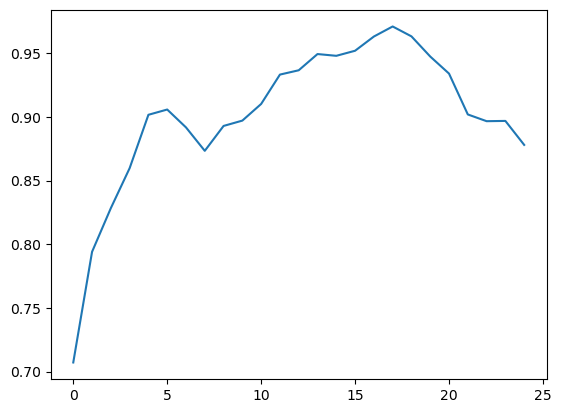

In [4]:
plt.plot(y_data)

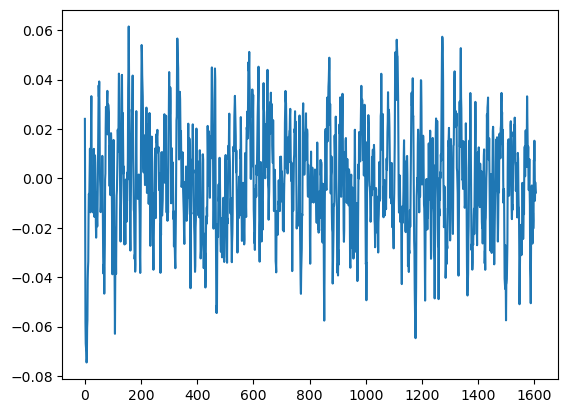

In [5]:
e_samples = e_data.reshape(-1,T+1)
plt.plot(e_data[10:])

In [57]:
### SLS optimization problem formulation

def add_block_lower_triangular_constraint(model, X, row_num, col_num, N):
    for i in range(N):
        for j in range(N):
            if i < j:
                for row in range(row_num):
                    for col in range(col_num):
                        model.addConstr(X[i*row_num + row, j*col_num + col] == 0)

def add_block_strictly_lower_triangular_constraint(model, X, row_num, col_num, N):
    for i in range(N):
        for j in range(N):
            if i <= j:
                for row in range(row_num):
                    for col in range(col_num):
                        model.addConstr(X[i*row_num + row, j*col_num + col] == 0)

y_lb = -0.01  ## set the lower bound of output
y_ub = 1.05
u_ub = 1
u_lb = -1

y_targ = 0.2 ### desired target of y

Q = 1
R = 0.01

var_ub = 1e20
var_lb = -1e20

# var_ub = 1e8
# var_lb = -1e8

def nominal_sls(G, Theta, y0_vec, e_vec, affine = True):
    model = gp.Model()
    Phi_y = model.addMVar(shape = (p*(T+1), p*(T+1)), lb = var_lb, ub = var_ub, vtype = GRB.CONTINUOUS)
    Phi_u = model.addMVar(shape = (m*(T+1), p*(T+1)), lb = var_lb, ub = var_ub, vtype = GRB.CONTINUOUS)
    phi_y = model.addMVar(shape = (p*(T+1), ), lb = var_lb, ub = var_ub, vtype = GRB.CONTINUOUS)
    phi_u = model.addMVar(shape = (m*(T+1), ), lb = var_lb, ub = var_ub, vtype = GRB.CONTINUOUS)

    ### SLS constraints
    model.addConstr( diag_I@Phi_y - G@Phi_u == diag_I)
    model.addConstr( diag_I@phi_y - G@phi_u == np.zeros(p*(T+1)))

    add_block_lower_triangular_constraint(model, Phi_y, p, p, T+1)
    add_block_strictly_lower_triangular_constraint(model, Phi_u, m, p, T+1)

    y_pre = model.addMVar(shape = (p*(T+1),), lb = var_lb, ub = var_ub, vtype = GRB.CONTINUOUS)
    model.addConstr(y_pre == Phi_y@(y0_vec+Theta@e_vec) + phi_y)

    u_pre = model.addMVar(shape = (m*(T+1),), lb = var_lb, ub = var_ub, vtype = GRB.CONTINUOUS)
    model.addConstr(u_pre == Phi_u@(y0_vec+Theta@e_vec) + phi_u)

    t_y = model.addMVar(shape = p*(T+1), vtype = GRB.CONTINUOUS)  ### auxillary variables for defining 1-norm of y
    model.addConstrs((y_pre[i] - y_targ  <= t_y[i] for i in range((T+1))))
    model.addConstrs((y_pre[i] - y_targ >= -t_y[i] for i in range((T+1))))

    t_u = model.addMVar(shape = (T+1), vtype = GRB.CONTINUOUS)  ### auxillary variables for defining 1-norm of u
    model.addConstrs((u_pre[i] <= t_u[i] for i in range((T+1))))
    model.addConstrs((u_pre[i] >= -t_u[i] for i in range((T+1))))


    # ### output constraint

    model.addConstr( (Phi_y@(y0_vec+Theta@e_vec) + phi_y) >= y_lb*np.ones(p*(T+1)) )
    # model.addConstr( Phi_u@(y0_vec+Theta@e_vec) + phi_u >= u_lb*np.ones(T+1))
    # model.addConstr( Phi_u@(y0_vec+Theta@e_vec) + phi_u <= u_ub*np.ones(T+1) )
    
    # model.addConstr( (Phi_y@(y0_vec+Theta@e_vec) + phi_y) <= y_ub*np.ones(p*(T+1)) )

    # model.addConstr(y_pre >= y_lb*np.ones(p*(T+1)))
    # model.addConstr(y_pre <= y_ub*np.ones(p*(T+1)))

    model.addConstrs((u_pre[t] <= u_ub for t in range(T+1)))
    model.addConstrs((u_pre[t] >= u_lb for t in range(T+1)))

    if affine == False:
        model.addConstr(phi_y == np.zeros(p*(T+1)))
        model.addConstr(phi_u == np.zeros(m*(T+1)))

    obj_2_norm = model.addVar(lb = 0, vtype = GRB.CONTINUOUS)
    
    model.addConstr(Q*sum(t_y[i]**2 for i in range(T+1)) + R*sum(t_u[i]**2 for i in range(T+1)) <= obj_2_norm*obj_2_norm  )
    
    #model.setObjective(Q*sum(t_y) + R*sum(t_u), sense = GRB.MINIMIZE)
    model.setObjective(obj_2_norm, sense = GRB.MINIMIZE)


    model.setParam("OutputFlag", 0)
    model.setParam('TimeLimit', 60)
    model.setParam("NonConvex", 2)
    # m.setParam("BarHomogeneous", 0)
    model.optimize()

    y_pre_comp = Phi_y.X@(y0_vec+Theta@e_vec) + phi_y.X
    u_pre_comp = Phi_u.X@(y0_vec+Theta@e_vec) + phi_u.X

    K = Phi_u.X@np.linalg.inv(Phi_y.X)
    g = phi_u.X - K@phi_y.X

    Phi = np.concatenate((Phi_y.X, Phi_u.X), axis = 0 )


    return y_pre.X, u_pre.X, K, g, model.ObjVal, Phi


In [58]:
### solve SLS problem for both affine and linear policies

#e_vec = e_samples[-1]
e_vec = np.zeros(T+1)

y_af, u_af, K_af, g_af, obj_af, Phi_af = nominal_sls(G, Theta, y0_vec, e_vec)
y_lr, u_lr, K_lr, g_lr, obj_lr, Phi_lr = nominal_sls(G, Theta, y0_vec, e_vec, affine  = False)

print("objective value of affine policy is: ", obj_af)
print("reduction percentage is: ", (obj_lr - obj_af)/obj_lr, "%")
print("objective value of linear policy is: ", obj_lr, "100%")

objective value of affine policy is:  1.2484478880386651
reduction percentage is:  0.04604803062933345 %
objective value of linear policy is:  1.3087114740821606 100%


In [59]:
K_lr

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.18920651e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.18920650e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.18920649e+00,  0.00000000e

combine norm is:  716.1789876501109
multiplicative norm is:  52.881053590360665


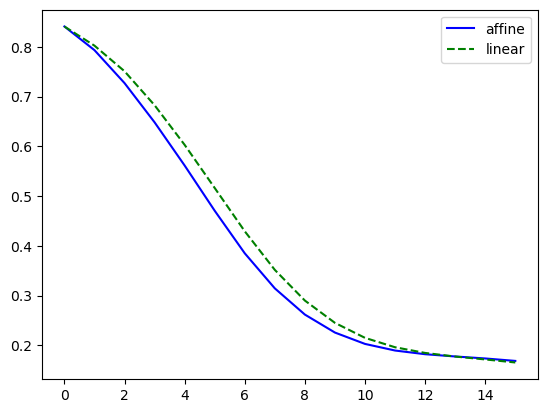

In [60]:
### This code snippet shows that the combined matrix norm can be further reduced

print("combine norm is: ", np.linalg.norm(Phi_af,1)*np.linalg.norm(y0_vec + Theta@e_samples[-1],1) )
print("multiplicative norm is: ", np.linalg.norm(Phi_af@(y0_vec+Theta@e_samples[-1]), 1))

plt.plot(y_af, "b", label = "affine")
plt.plot(y_lr, "g--", label = "linear")
plt.legend()

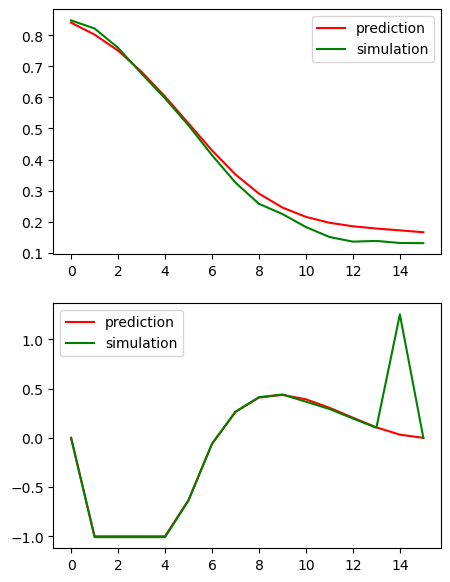

In [61]:
### closed-loop simulation
def closed_loop_simu(K, g, y_pre, u_pre, x_init = init_state, plot = "False"):
    y_simu =  np.array([])
    u_simu =  np.array([])

    lsys.reset(x_init = x_init)
    for t in range(T+1):
        y = lsys.y

        y_simu = np.append(y_simu, y)

        u = sum(K[t,i]*y_simu[i] for i in range(t)) + g[t]

        lsys.step(np.array([u]))
        u_simu = np.append(u_simu, u)

    real_obj = Q*np.linalg.norm((y_simu - y_targ), 1) + R*np.linalg.norm(u_simu, 1)
        
    if plot == True:
        plt.figure(figsize = (5,7))
        plt.subplot(211)
        plt.plot(y_pre, "r", label = "prediction")
        plt.plot(y_simu, "g", label = "simulation")
        plt.legend()
        
        plt.subplot(212)
        plt.plot(u_pre, "r", label = "prediction")
        plt.plot(u_simu, "g", label = "simulation")
        plt.legend()

    return y_simu, u_simu, real_obj


policy = "linear"

if policy == "affine":
    closed_loop_simu(K_af, g_af, y_af, u_af, plot = True)
elif policy == "linear":
    closed_loop_simu(K_lr, g_lr, y_lr, u_lr, plot = True)

In [53]:
### DR_SLS formulation
# Q = 1
# R = 0.1

# y_lb = -0
# u_ub = 2
# u_lb = -2

beta = 0.2 # the probability for CVAR constraint
constraint_type = "cvar"
constraint_satis = "all"

############################################
### this kind of definitions are wrong for 1-norm, not used in simulation
############################################
# a_mat = np.kron(np.array([[1],[-1]]), np.concatenate((Q*np.ones(T+1), R*np.ones(T+1))))
# b_mat = np.zeros(2)

c_mat_y1 = np.concatenate((-np.eye(T+1), np.zeros((T+1, m*(T+1)))), axis = 1) ###  system constraints c*eta + d <= 0
c_mat_y2 = np.concatenate((np.eye(T+1), np.zeros((T+1, m*(T+1)))), axis = 1)
#c_mat_y = np.concatenate((c_mat_y1, c_mat_y2), axis = 0)
c_mat_y = c_mat_y1

d_mat_y1 = y_lb*np.ones(T+1)
d_mat_y2 = -y_ub*np.ones(T+1)
#d_mat_y = np.concatenate((d_mat_y1, d_mat_y2))
d_mat_y = d_mat_y1

c_mat_u = np.concatenate((np.zeros((2*(T+1), T+1)), np.concatenate((np.eye(T+1), -np.eye(T+1)), axis = 0)), axis = 1)
d_mat_u = np.concatenate( (-u_ub*np.ones(T+1), u_lb*np.ones(T+1)) )

c_mat = np.concatenate((c_mat_y, c_mat_u), axis = 0)
d_mat = np.concatenate((d_mat_y, d_mat_u))                


# obj_list = range(len(a_mat))
cons_list = range(len(c_mat))

#rho = 0.1  ### rho/gamma1 is the bound of ||Phi_u||
# gamma1 = 0.03 ### uncertainty size of G
# gamma2 = 0.03 ### uncertainty size of Theta
# gamma3 = 0.03 ### uncertainty size of y_0
# #sigma = 500 ### bounds of ||Phi_y||
# kappa = 0.01### Wasserstein distance

gamma1 = 0.01 ### uncertainty size of G
gamma2 = 0.01 ### uncertainty size of Theta
gamma3 = 0.01 ### uncertainty size of y_0
#sigma = 500 ### bounds of ||Phi_y||
kappa = 0.005### Wasserstein distance

# lh = max([np.linalg.norm(a_mat[i], np.inf) for i in range(len(a_mat))])
# lg = max([np.linalg.norm(c_mat[i], np.inf) for i in range(len(c_mat))])
lh = max(Q,R)  ## infinity norm
lg = 1

def DR_SLS(G_hat, Theta_hat, y0_hat, e_samples, constraint_type = "expect", affine = True):

    N = len(e_samples)
    model = gp.Model()

    rho = model.addVar(ub = 0.999, vtype = GRB.CONTINUOUS)
    sigma = model.addVar(ub = 1000, vtype = GRB.CONTINUOUS)
    
    varepsilon = model.addVar(lb = 0, ub = var_ub, vtype = GRB.CONTINUOUS)
    
    Phi_y = model.addMVar(shape = (p*(T+1), p*(T+1)), lb = var_lb, vtype = GRB.CONTINUOUS)
    Phi_u = model.addMVar(shape = (m*(T+1), p*(T+1)), lb = var_lb, vtype = GRB.CONTINUOUS)
    phi_y = model.addMVar(shape = (p*(T+1), ), lb = var_lb, vtype = GRB.CONTINUOUS)
    phi_u = model.addMVar(shape = (m*(T+1), ), lb = var_lb, vtype = GRB.CONTINUOUS)

    if affine == False:
        model.addConstr(phi_y == np.zeros(T+1))
        model.addConstr(phi_u == np.zeros(T+1))

    ### SLS constraints
    model.addConstr( diag_I@Phi_y - G_hat@Phi_u == diag_I)
    model.addConstr( diag_I@phi_y - G_hat@phi_u == np.zeros(p*(T+1)))

    add_block_lower_triangular_constraint(model, Phi_y, p, p, T+1)
    add_block_strictly_lower_triangular_constraint(model, Phi_u, m, p, T+1)

    ### predicted output-input samples
    eta_samples = model.addMVar(shape = (N, (m+p)*(T+1)), lb = var_lb, vtype = GRB.CONTINUOUS)
    y_samples = model.addMVar(shape = (N, p*(T+1)), lb = var_lb, vtype = GRB.CONTINUOUS)
    u_samples = model.addMVar(shape = (N, m*(T+1)), lb = var_lb, vtype = GRB.CONTINUOUS)

    model.addConstr(eta_samples[:,:p*(T+1)] == y_samples)
    model.addConstr(eta_samples[:,p*(T+1):] == u_samples)

    y_up = model.addMVar(shape = (N, p*(T+1)), lb = 0, vtype = GRB.CONTINUOUS)
    u_up = model.addMVar(shape = (N, m*(T+1)), lb = 0, vtype = GRB.CONTINUOUS)

    model.addConstr(y_up >= y_samples - y_targ)
    model.addConstr(y_up >= -y_samples + y_targ)
    model.addConstr(u_up >= u_samples)
    model.addConstr(u_up >= -u_samples)

    s = model.addMVar(shape = (N,), lb = var_lb, vtype = GRB.CONTINUOUS)

    if constraint_type == "expect":
        q = model.addMVar(shape = (N, ), lb = var_lb, vtype = GRB.CONTINUOUS)
        model.addConstr(lg*varepsilon + 1/N*gp.quicksum(q) <= 0)
        
    elif constraint_type == "cvar":
        q = model.addMVar(shape = (N, ), lb = 0, vtype = GRB.CONTINUOUS)
        t = model.addVar(lb = -np.float64(np.inf), vtype = GRB.CONTINUOUS)
        model.addConstr(lg*varepsilon + 1/N*gp.quicksum(q) <= t*beta)
    else:
        print("Constraint Type is not correctly defined!!!")

    model.addConstrs( (Q*gp.quicksum(y_up[i,:]) + R*gp.quicksum(u_up[i,:]) <= s[i] for i in range(N)) )

    for i in range(N):
        model.addConstr( y_samples[i,:] == Phi_y@(y0_hat + Theta_hat@e_samples[i]) + phi_y)
        model.addConstr( u_samples[i,:] == Phi_u@(y0_hat + Theta_hat@e_samples[i]) + phi_u)

        for k in cons_list:
            if constraint_type == "expect":
                model.addConstr(c_mat[k,:]@eta_samples[i,:] + d_mat[k] <= q[i])
            
            elif constraint_type == "cvar":         
                model.addConstr(c_mat[k,:]@eta_samples[i,:] + d_mat[k] + t <= q[i] )
            

    Phi_y_up = model.addMVar(shape = (p*(T+1), p*(T+1)), lb = 0, vtype = GRB.CONTINUOUS)
    Phi_u_up = model.addMVar(shape = (m*(T+1), p*(T+1)), lb = 0, vtype = GRB.CONTINUOUS)

    phi_y_up = model.addMVar(shape = (p*(T+1), ), lb = 0, vtype = GRB.CONTINUOUS)
    phi_u_up = model.addMVar(shape = (m*(T+1), ), lb = 0, vtype = GRB.CONTINUOUS)

    model.addConstr(Phi_y <= Phi_y_up)
    model.addConstr(-Phi_y <= Phi_y_up)
    model.addConstr(Phi_u <= Phi_u_up)
    model.addConstr(-Phi_u <= Phi_u_up)

    model.addConstr(phi_y_up >= phi_y)
    model.addConstr(phi_y_up >= -phi_y)
    model.addConstr(phi_u_up >= phi_u)
    model.addConstr(phi_u_up >= -phi_u)

    Phi_y_norm = model.addVar(lb = 0, vtype = GRB.CONTINUOUS)
    Phi_u_norm = model.addVar(lb = 0, vtype = GRB.CONTINUOUS)

    Phi_norm = model.addVar(lb = 0, vtype = GRB.CONTINUOUS)
    phi_u_norm = model.addVar(lb = 0, vtype = GRB.CONTINUOUS)

    #model.addConstr(phi_norm >= gp.quicksum(phi_y_up) + gp.quicksum(phi_u_up))

    model.addConstrs( (Phi_u_norm >= gp.quicksum(Phi_u_up[:,i]) for i in range(p*(T+1))) )
    model.addConstrs( (Phi_y_norm >= gp.quicksum(Phi_y_up[:,i]) for i in range(p*(T+1))) )

    model.addConstr( (phi_u_norm >= gp.quicksum(phi_u_up)) )
    
    model.addConstrs( (Phi_norm >= gp.quicksum(Phi_y_up[:,i]) + gp.quicksum(Phi_u_up[:,i]) for i in range(p*(T+1))) )
    
    model.addConstr( (1-rho)*varepsilon >= 1/(N)*Phi_norm*(sum( rho*np.linalg.norm(y0_hat+Theta_hat@e_samples[i], 1) + gamma2*np.linalg.norm(e_samples[i],1) for i in range(N) ) + N*gamma3)
                   + (rho/gamma1 + sigma)*(gamma1)*phi_u_norm + kappa*Phi_norm*(np.linalg.norm(Theta_hat, 1) + gamma2) )
    
    model.addConstr(Phi_u_norm <= rho/gamma1)
    model.addConstr(Phi_y_norm <= sigma)

    model.setObjective(lh*varepsilon + 1/N*gp.quicksum(s), GRB.MINIMIZE)
    model.setParam("OutputFlag", 0)
    model.setParam('TimeLimit', 600)
    model.setParam("Nonconvex", 2)

    model.optimize()

    # print("\n Wasserstein bound is: ", varepsilon.X)
    # print("\n upper bound of q is: ", np.sum(q.X, axis = 0)/N)
    # print("\n phi norm is: ", phi_norm.X)
    # print("\n Phi norm is: ", Phi_norm.X)
    # print("\n phi_u is: ", phi_u.X)
    # print("\n phi_y is: ", phi_y.X)
    # print("\n Phi_u is: ", Phi_u.X)
    # print("\n Phi_y is: ", Phi_y.X)
    # print("\n phi_u_up is: ", phi_u_up.X)

    y_pre_avg = np.mean(y_samples.X, axis = 0)
    u_pre_avg = np.mean(u_samples.X, axis = 0)

    #y_pre = Phi_y.X@y0_vec + phi_y.X
    #u_pre = Phi_u.X@y0_vec + phi_u.X

    K = Phi_u.X@np.linalg.inv(Phi_y.X)
    g = phi_u.X - K@phi_y.X


    return y_pre_avg, u_pre_avg, K, g, model.ObjVal, eta_samples.X


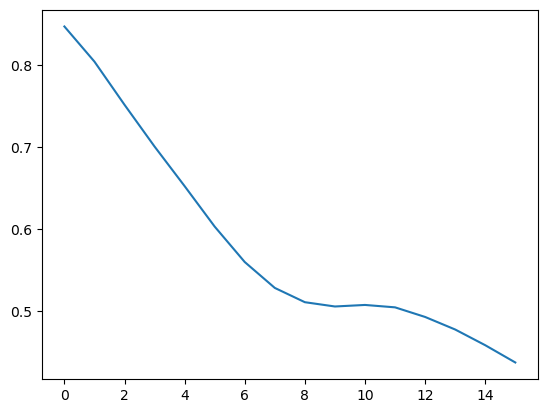

In [27]:
y, u, K, g, obj, _ = DR_SLS(G, Theta, y0_vec, e_samples, constraint_type = "expect")
plt.plot(y)

In [ ]:
### simulation ###
### For each loop, a set of uncertain parameters (G_hat, Theta_hat, y0_hat, e_samples)

params_list = []
A_list = []
B_list = []
C_list = []

### Given A, B，C, to generate parameters (G_hat, Theta_hat, y0_hat)
def generate_params(gamma1, gamma2, gamma3):
    ### gamma1, gamma2, gamma3 are upperbound of G, Theta, y0
    params_num = 0
    scaler = 0.2  ## influence whether the params list can be quickly generated.
    while params_num < 20:
        A_hat = A + scaler*(gamma1+gamma2+gamma3)*(np.random.rand(*A.shape) - 0.5)
        B_hat = B + scaler*(gamma1+gamma2+gamma3)*(np.random.rand(*B.shape) - 0.5)
        C_hat = C + scaler*(gamma1+gamma2+gamma3)*(np.random.rand(*C.shape) - 0.5)
    
        Tu_hat = gen_toep(A_hat,B_hat,T)
        Te_hat = gen_toep(A_hat,L,T)
    
        Psi_u_hat = gen_Psi(B_hat, tau)
        Psi_y_hat = gen_Psi(L, tau)
        diag_C_hat = gen_block_diag(C_hat, T+1)
    
        Gamma_hat = gen_Gamma(A_hat, T)
        G_hat = diag_C_hat@Tu_hat
        Theta_hat = diag_C_hat@Te_hat + diag_I

        y0_hat = diag_C_hat@Gamma_hat@(Psi_u_hat@u_data + Psi_y_hat@y_data)

        if np.linalg.norm(G - G_hat, 1) <= gamma1 and np.linalg.norm(Theta - Theta_hat, 1) <= gamma2 and np.linalg.norm(y0_vec - y0_hat) <= gamma3:
            params_num += 1
            params_list.append((G_hat, Theta_hat, y0_hat))
            A_list.append(A_hat)
            B_list.append(B_hat)
            C_list.append(C_hat)
            
            print(params_num)

    return None            

generate_params(gamma1, gamma2, gamma3)

In [ ]:
[np.linalg.norm(A_list[i] - A, 1) for i in range(len(params_list))]

In [ ]:
A_list[2]

In [ ]:
### simulate the closed-loop system
y_dro_ol_list = []
y_dro_cl_list = []
u_dro_ol_list = []
u_dro_cl_list = []
obj_dro_ol_list = []
obj_dro_cl_list = []

y_nominal_ol_list = []
y_nominal_cl_list = []
u_nominal_ol_list = []
u_nominal_cl_list = []
obj_nominal_ol_list = []
obj_nominal_cl_list = []

simu_num = 1

policy_affine = True

e_vec = np.mean(e_samples, axis = 0)
for params in tqdm(params_list):  ### params contains (G_hat, Theta_hat, y0_hat)
    
    y_pre_dro, u_pre_dro, K_dro, g_dro, obj_dro, _ = DR_SLS(*params, e_samples, affine = policy_affine)
    y_pre_nominal, u_pre_nominal, K_nominal, g_nominal, obj_nominal, _ = nominal_sls(*params, e_vec, affine = policy_affine)
    

    y_simu_nominal_list = []
    u_simu_nominal_list = []
    obj_simu_nominal_list = []
    
    y_simu_dro_list = []
    u_simu_dro_list = []
    obj_simu_dro_list = []
    
    for k in range(simu_num):
        y_simu_dro, u_simu_dro, obj_simu_dro = closed_loop_simu(K_dro, g_dro, y_pre_dro, u_pre_dro)
        y_simu_nominal, u_simu_nominal, obj_simu_nominal = closed_loop_simu(K_nominal, g_nominal, y_pre_nominal, u_pre_nominal)
        
        y_simu_nominal_list.append(y_simu_nominal)
        u_simu_nominal_list.append(u_simu_nominal)
        obj_simu_nominal_list.append(obj_simu_nominal)
        
        y_simu_dro_list.append(y_simu_dro)
        u_simu_dro_list.append(u_simu_dro)
        obj_simu_dro_list.append(obj_simu_dro)
        
    
    y_dro_ol_list.append(y_pre_dro)
    u_dro_ol_list.append(u_pre_dro)
    obj_dro_ol_list.append(obj_dro)
    
    y_dro_cl_list.append(np.mean(y_simu_dro_list, axis = 0))
    u_dro_cl_list.append(np.mean(u_simu_dro_list, axis = 0))
    obj_dro_cl_list.append(np.mean(obj_simu_dro_list, axis = 0))


    y_nominal_ol_list.append(y_pre_nominal)
    u_nominal_ol_list.append(u_pre_nominal)
    obj_nominal_ol_list.append(obj_nominal)
    
    y_nominal_cl_list.append(np.mean(y_simu_nominal_list, axis = 0))
    u_nominal_cl_list.append(np.mean(u_simu_nominal_list, axis = 0))
    obj_nominal_cl_list.append(np.mean(obj_simu_nominal_list, axis =0))

In [ ]:
g_dro

In [ ]:
#############################################
### simulation results of N-SLS
#############################################


y_nominal_ol_mat = np.array(y_nominal_ol_list).T
y_nominal_cl_mat = np.array(y_nominal_cl_list).T

u_nominal_ol_mat = np.array(u_nominal_ol_list).T
u_nominal_cl_mat = np.array(u_nominal_cl_list).T

y_dro_ol_mat = np.array(y_dro_ol_list).T
y_dro_cl_mat = np.array(y_dro_cl_list).T

u_dro_ol_mat = np.array(u_dro_ol_list).T
u_dro_cl_mat = np.array(u_dro_cl_list).T

fontsize = {"fontsize": 12.5}
fontname = {"fontname": "Times New Roman"}

fig, ax = plt.subplots(2,2, figsize = (6,6))
ax[0,0].plot(y_nominal_ol_mat)
ax[0,0].set_title("(a)predicted output", loc = "left", **fontsize, **fontname)
#ax[0,0].plot(y_lb*np.ones(T+1), "k--", label = "output lower bound")
ax[0,0].plot(y_ub*np.ones(T+1), "k--", label = "output upper bound")
ax[0,0].set_xlabel("time step", **fontsize, **fontname)
ax[0,0].set_ylabel("$y$", **fontsize, **fontname)
ax[0,0].legend(frameon = False)

ax[0,1].plot(u_nominal_ol_mat)
ax[0,1].set_title("(b) predicted input", loc = "left", **fontsize, **fontname)
ax[0,1].plot(u_lb*np.ones(T+1), "k--", label = "input bounds")
ax[0,1].plot(u_ub*np.ones(T+1), "k--")
ax[0,1].set_xlabel("time step", **fontsize, **fontname)
ax[0,1].set_ylabel("$u$", **fontsize, **fontname)
ax[0,1].legend(loc = 0, frameon = False)

ax[1,0].plot(y_nominal_cl_mat)
ax[1,0].set_title("(c) closed-loop output", loc = "left", **fontsize, **fontname)
#ax[1,0].set_xlim(0,T+1)
ax[1,0].plot(y_lb*np.ones(T+1), "k--", label = "output lower bound")
#ax[1,0].plot(y_ub*np.ones(T+1), "k--", label = "output upper bound")
ax[1,0].set_xlabel("time step", **fontsize, **fontname)
ax[1,0].set_ylabel("$y$", **fontsize, **fontname)
ax[1,0].legend(loc = 0, frameon = False)
# plt.savefig("nominal_sls.pdf", bbox_inches = "tight" )



ax[1,1].plot(u_nominal_cl_mat)
ax[1,1].set_title("(d) closed-loop input", loc = "left", **fontsize, **fontname)
ax[1,1].set_xlim(0,T+1)
ax[1,1].plot(u_lb*np.ones(T+1), "k--", label = "input bounds")
ax[1,1].plot(u_ub*np.ones(T+1), "k--")
ax[1,1].set_xlabel("time step", **fontsize, **fontname)
ax[1,1].set_ylabel("$u$", **fontsize, **fontname)
ax[1,1].legend(frameon = False, loc = 4)
plt.tight_layout()

#plt.savefig("NSLS_simu.pdf", bbox_inches = "tight")


In [ ]:
##############################################
### simulation results of DR-SLS
##############################################
fig, ax = plt.subplots(2,2, figsize = (6,6))
ax[0,0].plot(y_dro_ol_mat)
ax[0,0].set_title("(a) predicted output", loc = "left", **fontsize, **fontname)
ax[0,0].plot(y_lb*np.ones(T+1), "k--", label = "output lower bound")
#ax[0,0].plot(y_ub*np.ones(T+1), "k--", label = "output upper bound")
ax[0,0].set_xlabel("time step", **fontsize, **fontname)
ax[0,0].set_ylabel("$y$", **fontsize, **fontname)
ax[0,0].legend(loc = 0, frameon = False)

ax[0,1].plot(u_dro_ol_mat)
ax[0,1].set_title("(b) predicted input", loc = "left", **fontsize, **fontname)
ax[0,1].plot(u_lb*np.ones(T+1), "k--", label = "input bounds")
ax[0,1].plot(u_ub*np.ones(T+1), "k--")
ax[0,1].set_xlabel("time step", **fontsize, **fontname)
ax[0,1].set_ylabel("$u$", **fontsize, **fontname)
ax[0,1].legend(loc = 4, frameon = False)


ax[1,0].plot(y_dro_cl_mat)
ax[1,0].set_title("(c) closed-loop output", loc = "left", **fontsize, **fontname)
#ax[1,0].set_xlim(0,T+1)
ax[1,0].plot(y_lb*np.ones(T+1), "k--", label = "output lower bound")
#ax[1,0].plot(y_ub*np.ones(T+1), "k--", label = "output upper bound")
ax[1,0].set_xlabel("time step", **fontsize, **fontname)
ax[1,0].set_ylabel("$y$", **fontsize, **fontname)
ax[1,0].legend(loc = 0, frameon = False)
# plt.savefig("nominal_sls.pdf", bbox_inches = "tight" )


ax[1,1].plot(u_dro_cl_mat)
ax[1,1].set_title("(d) closed-loop input", loc = "left", **fontsize, **fontname)
#ax[1,1].set_xlim(0,T)
ax[1,1].plot(u_lb*np.ones(T+1), "k--", label = "input bounds")
ax[1,1].plot(u_ub*np.ones(T+1), "k--")
ax[1,1].set_xlabel("time step", **fontsize, **fontname)
ax[1,1].set_ylabel("$u$", **fontsize, **fontname)
ax[1,1].legend(loc = 4, frameon = False)
plt.tight_layout()
#plt.savefig("DRSLS_simu.pdf", bbox_inches = "tight")

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (5,6))
ax[0].plot(u_nominal_ol_mat)
ax[0].set_title("(a) N-SLS open-loop input prediction", loc = "left", **fontsize, **fontname)
ax[0].plot(u_lb*np.ones(T+1), "k--", label = "input bounds")
ax[0].plot(u_ub*np.ones(T+1), "k--")
ax[0].set_xlabel("time step", **fontsize, **fontname)
ax[0].set_ylabel("$u$", **fontsize, **fontname)
ax[0].legend()

ax[1].plot(u_nominal_cl_mat[:5])
ax[1].set_title("(b) N-SLS closed-loop input trajectory", loc = "left", **fontsize, **fontname)
ax[1].set_xlim(0,15)
ax[0].plot(u_lb*np.ones(T+1), "k--", label = "input bounds")
ax[0].plot(u_ub*np.ones(T+1), "k--")
ax[1].set_xlabel("time step", **fontsize, **fontname)
ax[1].set_ylabel("$u$", **fontsize, **fontname)
plt.tight_layout()
ax[1].legend()
plt.savefig("nominal_sls_input.pdf", bbox_inches = "tight" )








fig, ax = plt.subplots(2,1, figsize = (5,6))
ax[0].plot(u_dro_ol_mat)
ax[0].set_title("(a) N-SLS open-loop input prediction", loc = "left", **fontsize, **fontname)
ax[0].plot(u_lb*np.ones(T+1), "k--", label = "input bounds")
ax[0].plot(u_ub*np.ones(T+1), "k--")
ax[0].set_xlabel("time step", **fontsize, **fontname)
ax[0].set_ylabel("$u$", **fontsize, **fontname)
ax[0].legend()

ax[1].plot(u_dro_cl_mat)
ax[1].set_title("(b) N-SLS closed-loop input trajectory", loc = "left", **fontsize, **fontname)
ax[1].set_xlim(0,15)
ax[1].plot(u_lb*np.ones(T+1), "k--", label = "input bounds")
ax[1].plot(u_ub*np.ones(T+1), "k--")
ax[1].set_xlabel("time step", **fontsize, **fontname)
ax[1].set_ylabel("$u$", **fontsize, **fontname)
plt.tight_layout()
ax[1].legend()
plt.savefig("dro_sls_input.pdf", bbox_inches = "tight" )

In [ ]:
# fontsize = {"fontsize": 12}
# fontname = {"fontname": "Times New Roman"}


# fig, ax = plt.subplots(2,1, figsize = (5,6.2))
# ax[0].plot(obj_dro_ol_list, "o", color = "b", label = "DR-SLS")
# ax[0].plot(obj_nominal_ol_list, "*", color = "r", label = "Nominal SLS")
# ax[0].set_title("(a) open-loop predicted objective value", loc = "left", **fontsize, **fontname)
# ax[0].set_ylim([0,1.8])
# ax[0].legend()

# ax[0].set_xlabel("simulation iteration", **fontsize, **fontname)
# plt.tight_layout()

# ax[1].plot(obj_dro_cl_list, "o", color = "b", label = "DR-SLS")
# ax1= ax[1].twinx()
# ax1.plot(obj_nominal_cl_list, "*", color = "r", label = "Nominal SLS")
# ax[1].legend(loc =2)
# ax[1].set_ylabel("DR-SLS", **fontsize, **fontname)
# ax[1].set_ylim([0,1.8])
# ax[1].set_ylabel("objective value", **fontsize, **fontname)
# ax[1].set_xlabel("simulation iteration", **fontsize, **fontname)
# ax[1].set_title("(b) closed-loop real objective value", loc = "left", **fontsize, **fontname)

# ax[1].set_ylabel("DR-SLS", **fontsize, **fontname)
# ax1.set_ylabel("Nominal SLS", **fontsize, **fontname)
# ax1.set_ylim([-5,1e2])
# ax1.legend(loc = 1)
# plt.tight_layout()

# plt.savefig("obj_sls.pdf", bbox_inches = "tight")

In [ ]:
obj_dro_ol_mat = np.array(obj_dro_ol_list)
obj_dro_cl_mat = np.array(obj_dro_cl_list)

obj_nominal_ol_mat = np.array(obj_nominal_ol_list)
obj_nominal_cl_mat = np.array(obj_nominal_cl_list)

percent_list = [0, 25, 50, 75, 100]
obj_dro_ol_percent = np.percentile(obj_dro_ol_mat, percent_list)
obj_dro_cl_percent = np.percentile(obj_dro_cl_mat, percent_list)

obj_nominal_ol_percent = np.percentile(obj_nominal_ol_mat, percent_list)
obj_nominal_cl_percent = np.percentile(obj_nominal_cl_mat, percent_list)

In [ ]:
#############################################
###  simulation results of objective values
#############################################
obj_data_ol = [obj_nominal_ol_mat, obj_dro_ol_mat]
obj_data_cl = [obj_nominal_cl_mat, obj_dro_cl_mat]
fig, ax = plt.subplots(1,2,figsize = (5,3.5))

box = ax[0].boxplot(obj_data_ol, patch_artist=True, showmeans=True, labels = ["N-SLS", "DR-SLS"])
ax[0].set_ylabel("objective value", **fontsize, **fontname)
ax[0].set_title("(a) open-loop objective value", **fontsize, **fontname)

colors = ['lightblue', 'lightblue']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

box = ax[1].boxplot([obj_nominal_cl_mat, []], patch_artist=True, showmeans=True, labels = ["N-SLS", "DR-SLS"])
#ax[1].set_ylim([0,1e3])
ax[1].set_ylabel("objective value of N-SLS", **fontsize, **fontname)
colors = ['lightblue', 'lightblue']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
ax[1].set_title("(b) closed-loop objective value", **fontsize, **fontname)

ax1 = ax[1].twinx()
box = ax1.boxplot([[], obj_dro_cl_mat], patch_artist=True, showmeans=True, labels = ["N-SLS", "DR-SLS"])
ax1.set_ylabel("objective value of DR-SLS", **fontsize, **fontname)
colors = ['lightblue', 'lightblue']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.tight_layout()
#plt.savefig("obj_err_bar.pdf", bbox_inches = "tight")


In [ ]:
def Regularized_SLS(G_hat, Theta_hat, y0_hat, e_samples, reg1, reg2):

    N = len(e_samples)
    model = gp.Model()
   
    
    Phi_y = model.addMVar(shape = (p*(T+1), p*(T+1)), lb = -1e10, ub = 1e10, vtype = GRB.CONTINUOUS)
    Phi_u = model.addMVar(shape = (m*(T+1), p*(T+1)), lb = -1e10, ub = 1e10, vtype = GRB.CONTINUOUS)
    phi_y = model.addMVar(shape = (p*(T+1), ), lb = var_lb, ub = var_ub, vtype = GRB.CONTINUOUS)
    phi_u = model.addMVar(shape = (m*(T+1), ), lb = var_lb, ub = var_ub, vtype = GRB.CONTINUOUS)

    ### SLS constraints
    model.addConstr( diag_I@Phi_y - G_hat@Phi_u == diag_I)
    model.addConstr( diag_I@phi_y - G_hat@phi_u == np.zeros(p*(T+1)))

    add_block_lower_triangular_constraint(model, Phi_y, p, p, T+1)
    add_block_strictly_lower_triangular_constraint(model, Phi_u, m, p, T+1)

    ### predicted output-input trajectory  (compared with DR-SLS, only one trajectory is used)
    y_samples = model.addMVar(shape = (p*(T+1)), lb = var_lb, ub = var_ub, vtype = GRB.CONTINUOUS)
    u_samples = model.addMVar(shape = (m*(T+1)), lb = var_lb, ub = var_ub, vtype = GRB.CONTINUOUS)

    y_norm = model.addMVar(shape = (p*(T+1)), lb = 0, ub = var_ub, vtype = GRB.CONTINUOUS)
    u_norm = model.addMVar(shape = (m*(T+1)), lb = 0, ub = var_ub, vtype = GRB.CONTINUOUS)

    model.addConstr(y_norm >= y_samples - y_targ)
    model.addConstr(y_norm >= -y_samples + y_targ)
    model.addConstr(u_norm >= u_samples)
    model.addConstr(u_norm >= -u_samples)

    model.addConstr( y_samples == Phi_y@(y0_hat + Theta_hat@e_samples) + phi_y)
    model.addConstr( u_samples == Phi_u@(y0_hat + Theta_hat@e_samples) + phi_u)

    ### input and output constraints
    model.addConstr(Phi_y@(y0_hat +Theta_hat@e_samples)+phi_y >= y_lb*np.ones(T+1))

    model.addConstr(Phi_u@(y0_hat +Theta_hat@e_samples)+phi_u >= u_lb*np.ones(T+1))
    model.addConstr(Phi_u@(y0_hat +Theta_hat@e_samples)+phi_u <= u_ub*np.ones(T+1))

    Phi_y_up = model.addMVar(shape = (p*(T+1), p*(T+1)), lb = 0, ub = var_ub, vtype = GRB.CONTINUOUS)
    Phi_u_up = model.addMVar(shape = (m*(T+1), p*(T+1)), lb = 0, ub = var_ub, vtype = GRB.CONTINUOUS)

    phi_y_up = model.addMVar(shape = (p*(T+1), ), lb = 0, ub = var_ub, vtype = GRB.CONTINUOUS)
    phi_u_up = model.addMVar(shape = (m*(T+1), ), lb = 0, ub = var_ub, vtype = GRB.CONTINUOUS)

    model.addConstr(Phi_y <= Phi_y_up)
    model.addConstr(-Phi_y <= Phi_y_up)
    model.addConstr(Phi_u <= Phi_u_up)
    model.addConstr(-Phi_u <= Phi_u_up)

    # Phi_y_norm = model.addVar(lb = 0, ub = var_ub, vtype = GRB.CONTINUOUS)
    # Phi_u_norm = model.addVar(lb = 0, ub = var_ub, vtype = GRB.CONTINUOUS)

    Phi_norm = model.addVar(lb = 0, ub = var_ub, vtype = GRB.CONTINUOUS)
    phi_u_norm = model.addVar(lb = 0, ub = var_ub, vtype = GRB.CONTINUOUS)

    model.addConstr(phi_u_norm >= gp.quicksum(phi_u_up))

    model.addConstrs( (Phi_norm >= gp.quicksum(Phi_y_up[:,i]) + gp.quicksum(Phi_u_up[:,i]) for i in range(p*(T+1))) )

    model.setObjective(Q*sum(y_norm) + R*sum(u_norm) + reg1*Phi_norm + reg2*phi_u_norm, GRB.MINIMIZE)
    model.setParam("OutputFlag", 0)
    model.setParam('TimeLimit', 600)
    #model.setParam("Nonconvex", 2)

    model.optimize()

    #print("Phi_u_up is: ", Phi_u_up.X)


    y_pre_avg = np.mean(y_samples.X, axis = 0)
    u_pre_avg = np.mean(u_samples.X, axis = 0)

    #y_pre = Phi_y.X@y0_vec + phi_y.X
    #u_pre = Phi_u.X@y0_vec + phi_u.X

    K = Phi_u.X@np.linalg.inv(Phi_y.X)
    g = phi_u.X - K@phi_y.X
    
    return y_samples.X, u_samples.X, K, g, model.ObjVal, None



In [ ]:
e_vec = np.mean(e_samples, axis = 0)

params = params_list[1]

reg1_base = np.logspace(-10, -2, num = 10)
reg2_base = np.logspace(-10, -2, num = 10)

reg1_mesh, reg2_mesh = np.meshgrid(reg1_base, reg2_base)

def batch_simu():

    simu_num = 10

    row, col = reg1_mesh.shape
    obj_pre_mesh = np.zeros_like(reg1_mesh)
    obj_simu_mesh = np.zeros_like(reg2_mesh)
    
    for i in range(row):
        for j in range(col):
            reg1 = reg1_mesh[i,j]
            reg2 = reg2_mesh[i,j]

            y_pre, u_pre, K_dro, g_dro, obj_dro, _ = Regularized_SLS(*params, e_vec, reg1, reg2)

            obj_simu_list = []
            for k in range(simu_num):
                y_simu, u_simu, obj_simu = closed_loop_simu(K_dro, g_dro, y_pre, u_pre)
                obj_simu_list.append(obj_simu)
                
            

            obj_pre_mesh[i,j] = obj_dro
            obj_simu_mesh[i,j] = np.mean(obj_simu_list)


    return obj_pre_mesh, obj_simu_mesh


In [ ]:
reg1 = 0
reg2 = 0
params = params_list[7]
y_pre, u_pre, K_dro, g_dro, obj_dro, _ = Regularized_SLS(*params, e_vec, reg1, reg2)
closed_loop_simu(K_dro, g_dro, y_pre, u_pre, plot = True)

In [ ]:
obj_pre_mesh, obj_simu_mesh = batch_simu()

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(reg1_mesh, reg2_mesh, obj_simu_mesh, cmap = "viridis")
ax.set_xlabel("$\eta_1$")
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

In [ ]:
# G_hat = G
# Theta_hat = Theta
# y0_hat = y0_vec
# e_samples =e_data.reshape(-1,T+1)[1:]

# y_dro, u_dro, K_dro, g_dro, obj_dro, eta = DR_SLS(G_hat, Theta_hat, y0_hat, rho, e_samples, constraint_type = "expect")

In [ ]:
plt.figure(figsize = (5,7))
plt.subplot(211)
plt.plot(np.mean(eta[:,:T], axis = 0), label = "average output")
plt.subplot(212)
plt.plot(np.mean(eta[:,T:], axis = 0), label = "average input")
plt.legend()

In [ ]:
closed_loop_simu(K_dro, g_dro, y_dro, u_dro)

In [ ]:
u_dro